Siccome il file `analisi.ipynb` è pieno di errori e non so come risolvere eccomi qui a rifare tutto da capo.
Yuppy
AAAAAAAAAAAAAAAAAAAAAAAA

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots  # noqa

plt.style.use(["science", "grid", "ieee"])

In [11]:
# Valori fisici
g = 9.806  # m/s^2
rho_o = 860  # kg/m^3
rho_a = 1.293  # kg/m^3
pressione = 101325 * 1.01  # Pa
b = 8.2e-3  # Pa m (costante correzione viscosa)
reticolo = 0.5  # mm

d_isolante = 7.1656  # mm

In [12]:
data = pd.read_excel("Dati_Raccolti_Puliti.xlsx", sheet_name="AllData",
                     header=None)

# print("Dati iniziali:\n", data)

# drop zero rows and columns
data = data.dropna(axis=1, how="all").dropna(axis=0, how="all")

max_gocce = 10
max_cols = 8
max_rows = 6

temperature = np.full(max_gocce, np.nan)
voltaggi = np.full((max_gocce, max_cols), np.nan)
tempi = np.full((max_gocce, max_cols, max_rows), np.nan)
temp = np.full((max_rows, max_cols), np.nan)
i = -1
m = 0
for row in data.to_numpy():
	if np.isnan(row[1:]).all():
		i += 1
		temperature[i] = row[0]
		if temp.any():
			for j in range(max_rows):
				for k in range(max_cols):
					tempi[i - 1, k, j] = temp[j, k]
			temp = np.full((max_rows, max_cols), np.nan)
			m = 0
	else:
		if row[0] == 0:
			for j, elem in enumerate(row):
				voltaggi[i, j] = elem
		else:
			for j, elem in enumerate(row):
				temp[m, j] = elem
			m += 1
else:
	for j in range(max_rows):
		for k in range(max_cols):
			tempi[i, k, j] = temp[j, k]

print("Temperature [°C]:\n", temperature)
print("Voltaggi [V/m]:\n", voltaggi)
print("Tempi [s]:\n", tempi)


Prima pulizia: 
         2       5       8       11      14      17      20      23
7    50.10     NaN    2.63    2.79     NaN     NaN     NaN     NaN
16   21.00     NaN     NaN     NaN     NaN     NaN     NaN     NaN
17    0.00  322.00 -323.00  323.00 -323.00  323.00 -323.00  323.00
19   14.82    2.98    4.52    3.10    5.13    3.06    4.60    3.01
20   17.88    2.87    4.83    2.94    4.64    3.04    4.73    2.97
21   14.05    3.04    4.98    3.09    4.73    2.99    4.62    3.10
22   15.24    3.08    4.59    2.95    4.76    3.10    4.67    3.05
23   16.16     NaN    5.18     NaN    4.97    3.20    4.58    3.05
46   22.00     NaN     NaN     NaN     NaN     NaN     NaN     NaN
47    0.00 -354.00  354.00     NaN     NaN     NaN     NaN     NaN
49    9.28    4.86    1.85     NaN     NaN     NaN     NaN     NaN
50   10.00    4.91    1.75     NaN     NaN     NaN     NaN     NaN
51   10.57    4.52    1.72     NaN     NaN     NaN     NaN     NaN
52    9.70    4.47    1.78     NaN     NaN   

# Funzioni

In [13]:
def calc_visco(t: float) -> float:
	# T deve essere in celsius
	return (1.8 + 4.765e-3 * (t - 15)) * 1e-5  # N s m^-2


def calc_radius(nu: float, vel: np.ndarray) -> np.ndarray:
	# ! non sono sicuro che il calcolo del raggio sia corretto
	return np.sqrt(
			(b / (2 * pressione)) ** 2 + (9 * nu * np.abs(vel)) / (
					2 * g * (rho_o - rho_a))
			) - b / (2 * pressione)  # m


# ? ma se rho cambia in fz della temperatura, qual è l'errore che ne viene
# fuori?

def calc_charge(r: float, v_r: float, e_field: float, v_e: np.ndarray) -> (np
.ndarray):
	return (-4 / 3 * np.pi * r ** 3 * (rho_o - rho_a) * g * (1 + v_e / v_r) /
	        e_field)

In [14]:
def calc_stats(arr: np.ndarray):
	# 2D array
	if arr.ndim == 2:
		return np.nanmean(arr, axis=1), np.nanstd(arr, axis=1, ddof=1)

	# 3D or greater are not implemented
	if arr.ndim > 2:
		raise ValueError("Cannot calculate for arrays with 2 dimensions")

	# 1D array
	return np.nanmean(arr), np.nanstd(arr, ddof=1)

## Analysis

In [15]:
# Show data collected
plot_row = np.ceil(np.sqrt(max_gocce)).astype(int)
plot_col = np.ceil(max_gocce / plot_row).astype(int)
fig, axs = plt.subplots(plot_col, plot_row,
                        figsize=(plot_row * 4, plot_col * 3))

# TODO fare con il senza campi
plt.suptitle("Tempi trascorsi (escluso senza campo)")
for i in range(max_gocce):
	n, m = i // plot_row, i % plot_row

	ax = axs[n, m]
	ax.set_title(f"Goccia {i + 1}")
	ax.set_xlabel("Set di misure")
	ax.set_ylabel(r"Tempo [$s$]")

	for j in range(1, max_cols):
		ax.scatter(j * np.ones(len(tempi[i, j, :max_rows])),
		           tempi[i, j, :max_rows])

plt.tight_layout()
plt.savefig("Images/Tempi trascorsi.svg")
plt.show()

In [16]:
# TODO ricontrollare questo pezzo di codice
charges = np.zeros((max_gocce, max_cols - 1))

for i in range(0, max_gocce):
	# Tempi
	print(f"~~~~~~~ Goccia {i + 1} ~~~~~~~")
	means_t, stds_t = calc_stats(tempi[i, :max_cols, :max_rows])
	print(
			f"Tempi e incertezza per set: \n\t"
			+ "\n\t".join(
					f"{a:.4g} ±{b:.2g}s" for a, b in zip(means_t, stds_t))
			)

	# Velocità
	velocita = (reticolo / 1000) / means_t
	print(
			f"Velocità e incertezza per set: \n\t"
			+ "\n\t".join(
					f"{a:.4g} ±{'NOT CALCULATED'}m/s" for a, b in
					zip(velocita, stds_t)
					)
			)

	# Raggio
	nu = calc_visco(temperature[i])  # ? unità di misura
	r = calc_radius(nu, velocita)
	mean_r, std_r = np.nanmean(r), np.nanstd(r, ddof=1)

	print(f"nu: {nu:.4g}")
	print(f"Raggio: {mean_r:.4g} ±{std_r:.2g}m")

	# Carica
	E = abs(voltaggi[i, 1:max_cols]) / (d_isolante / 1000)
	print(
			f"Campo elettrico per set (2-{max_cols}): \n\t"
			+ "\n\t".join(f"{e:.3g} ±{'NOT CALCULATED'} V/m" for e in E)
			)

	q = calc_charge(mean_r, velocita[0], E, velocita[1:])
	print(
			f"Carica e incertezza per set (2-{max_cols}): \n\t"
			+ "\n\t".join(f"{a:.4g} ±{'NOT CALCULATED'} C" for a, b in
			              zip(q, stds_t[1:]))
			)
	charges[i] += q

~~~~~~~ Goccia 1 ~~~~~~~
Tempi e incertezza per set: 
	54.2 ±5.1s
	nan ±nans
	2.62 ±0.048s
	2.777 ±0.042s
	nan ±nans
	nan ±nans
	nan ±nans
	nan ±nans
Velocità e incertezza per set: 
	9.225e-06 ±NOT CALCULATEDm/s
	nan ±NOT CALCULATEDm/s
	0.0001908 ±NOT CALCULATEDm/s
	0.0001801 ±NOT CALCULATEDm/s
	nan ±NOT CALCULATEDm/s
	nan ±NOT CALCULATEDm/s
	nan ±NOT CALCULATEDm/s
	nan ±NOT CALCULATEDm/s
nu: 1.829e-05
Raggio: 9.587e-07 ±6e-07m
Campo elettrico per set (2-8): 
	nan ±NOT CALCULATED V/m
	4.49e+04 ±NOT CALCULATED V/m
	4.49e+04 ±NOT CALCULATED V/m
	nan ±NOT CALCULATED V/m
	nan ±NOT CALCULATED V/m
	nan ±NOT CALCULATED V/m
	nan ±NOT CALCULATED V/m
Carica e incertezza per set (2-8): 
	nan ±NOT CALCULATED C
	-1.5e-17 ±NOT CALCULATED C
	-1.419e-17 ±NOT CALCULATED C
	nan ±NOT CALCULATED C
	nan ±NOT CALCULATED C
	nan ±NOT CALCULATED C
	nan ±NOT CALCULATED C
~~~~~~~ Goccia 2 ~~~~~~~
Tempi e incertezza per set: 
	15.63 ±1.5s
	2.993 ±0.091s
	4.82 ±0.27s
	3.02 ±0.087s
	4.846 ±0.2s
	3.078 ±0.079s
	4.64

/var/folders/h4/lp363j8s0xd_71n6qf896t0r0000gn/T/ipykernel_95364/1365218415.py:4: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr, axis=1), np.nanstd(arr, axis=1, ddof=1)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [17]:
plot_row = np.ceil(np.sqrt(max_gocce)).astype(int)
plot_col = np.ceil(max_gocce / plot_row).astype(int)
fig, axs = plt.subplots(plot_col, plot_row,
                        figsize=(plot_row * 4, plot_col * 3))

for i in range(max_gocce):
	x = np.linspace(1.5e-19, 1.7e-19, 1000)
	print("Carica [C]: " + " ".join(f"{charge:.3g}" for charge in charges[i]))
	y = 0
	for charge in charges[i]:
		if np.isnan(charge):
			continue
		y += np.square(x - charge / np.round(charge / x))

	n, m = i // plot_row, i % plot_row
	axs[n, m].plot(x, y)

	axs[n, m].set_title(f"Goccia {i + 1}")
	axs[n, m].set_xlabel(r"Carica $q$ [C]")
	axs[n, m].set_ylabel(r"$S(q)$ [C$^2$]")

plt.tight_layout()
plt.suptitle(r"$S(q)$ in funzione di $q$")
plt.savefig("Images/Carica delle gocce.svg")
plt.show()

Carica [C]: nan -1.5e-17 -1.42e-17 nan nan nan nan
Carica [C]: -5.57e-18 -3.79e-18 -5.52e-18 -3.77e-18 -5.43e-18 -3.9e-18 -5.49e-18
Carica [C]: -2.82e-18 -6e-18 nan nan nan nan nan
Carica [C]: nan nan nan -2.38e-17 -1.86e-17 -2.35e-17 -1.89e-17
Carica [C]: -4.56e-18 -6.87e-18 -6.03e-18 -8.3e-18 -6.22e-18 -8.09e-18 -6e-18
Carica [C]: -5.97e-18 -7.63e-18 -5.84e-18 -6.91e-18 -6.01e-18 -6.96e-18 -5.79e-18
Carica [C]: -2.33e-17 -2.74e-17 -2.4e-17 -2.76e-17 nan nan nan
Carica [C]: -4.9e-18 -7.08e-18 -4.81e-18 -7e-18 -4.79e-18 -6.94e-18 -4.78e-18
Carica [C]: -7.06e-18 -1.05e-17 -7.23e-18 -9.01e-18 -5.29e-18 -8.69e-18 nan
Carica [C]: -2.54e-17 -2.88e-17 -2.42e-17 -2.84e-17 -2.43e-17 -2.96e-17 -2.5e-17


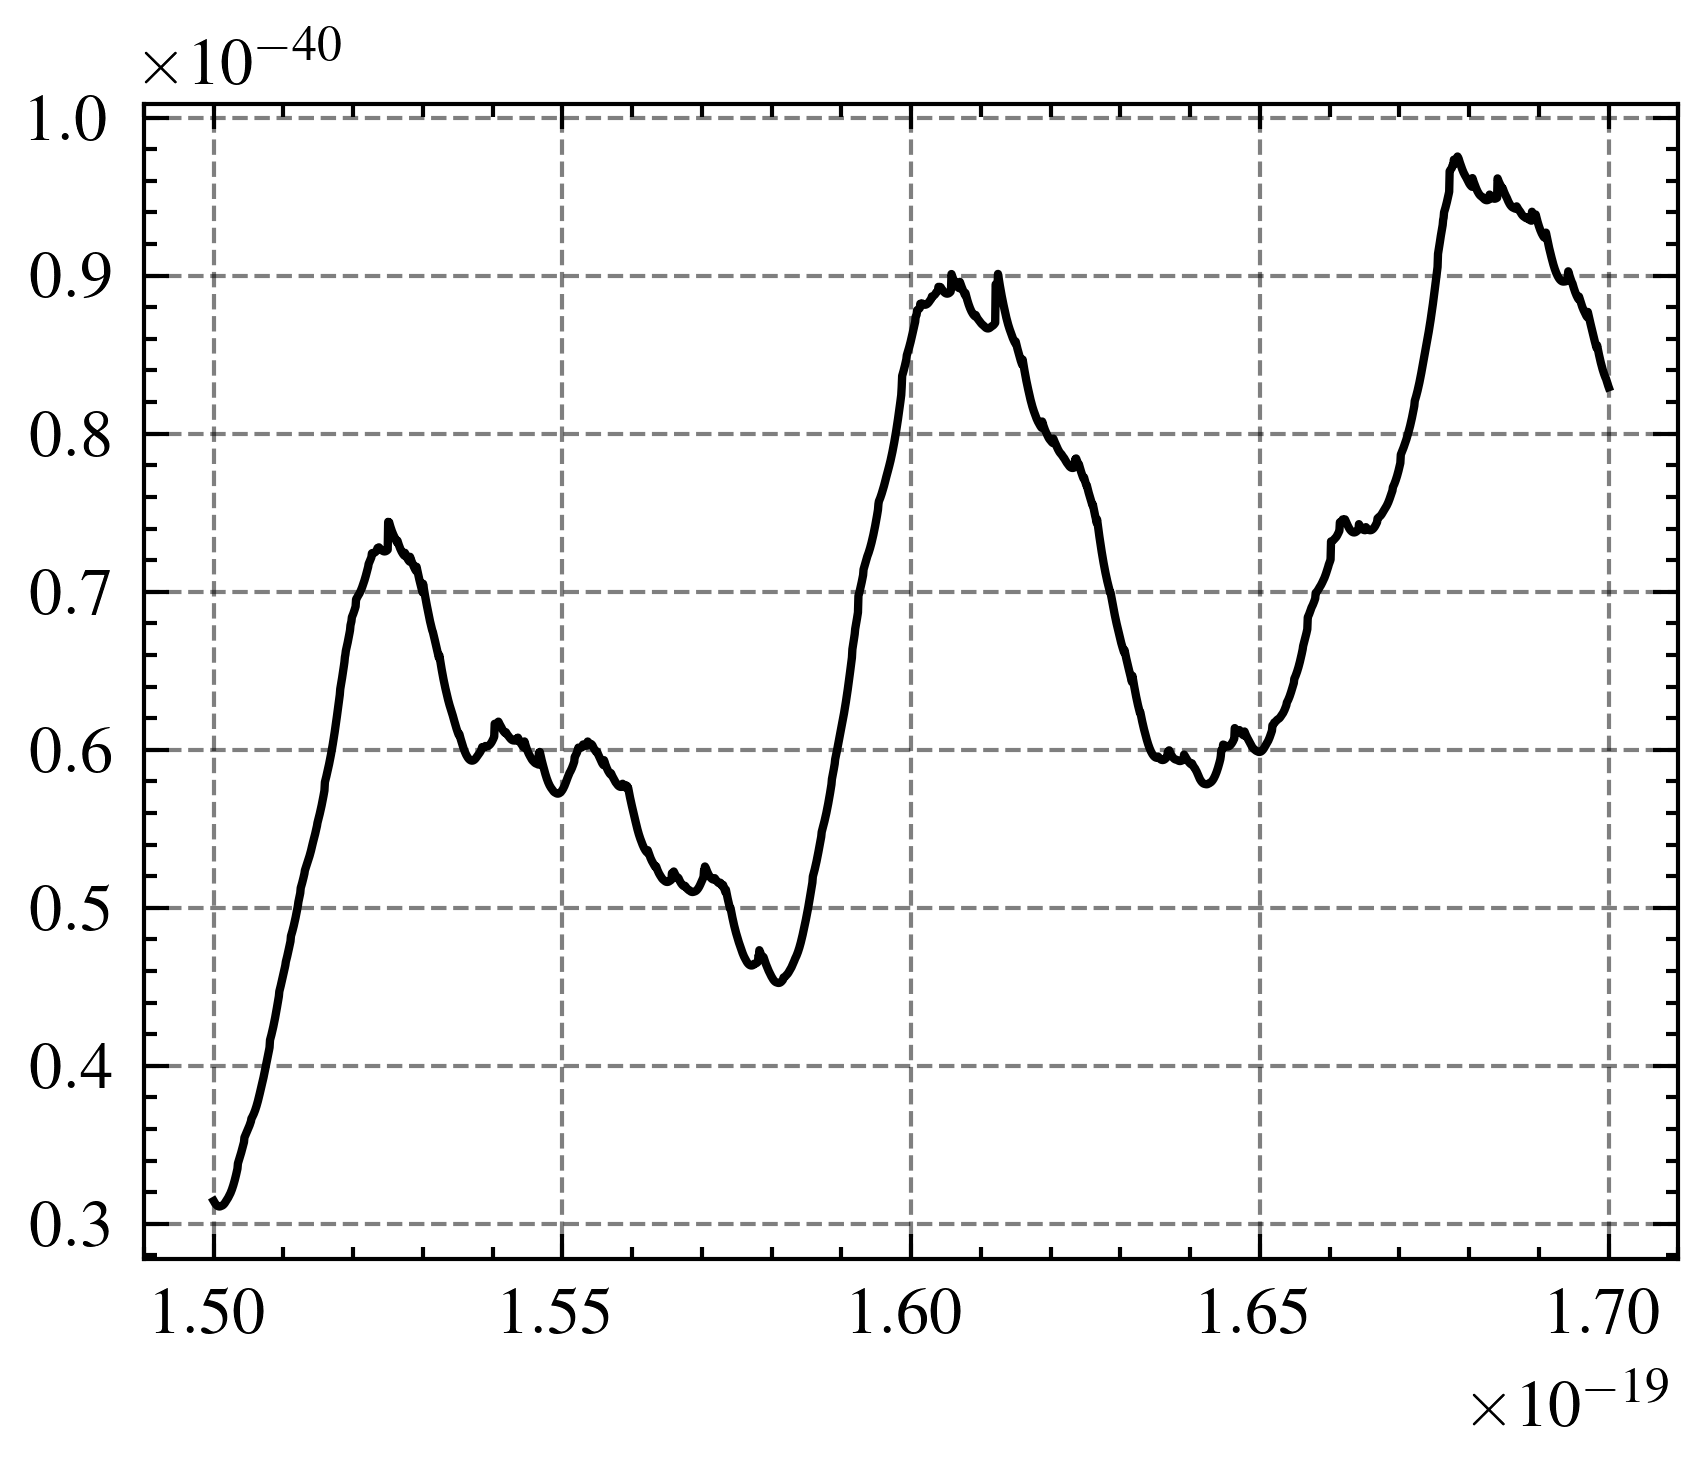

In [18]:
charges = charges.flatten()

fig, ax = plt.subplots()

x = np.linspace(1.5e-19, 1.7e-19, 3000)
y = 0
for charge in charges:
	if not np.isnan(charge):
		y += np.square(x - charge / np.round(charge / x))

plt.plot(x, y)
plt.show()